# AF Lep 4S - Fake Planets

## 1. Imports

In [1]:
from pathlib import Path
import numpy as np
from scipy.ndimage import gaussian_filter

# Plotting
import cmocean
import matplotlib.pylab as plt
color_map = cmocean.cm.ice
import seaborn as sns
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

# Methods
from fours.models.psf_subtraction import FourS
from fours.utils.pca import pca_psf_subtraction_gpu
from fours.utils.data_handling import read_fours_root_dir
from fours.utils.data_handling import save_as_fits

# Pynpoint
from pynpoint.util.analysis import fake_planet

# AppleFy
from applefy.utils.file_handling import load_adi_data, open_fits
from applefy.detections.uncertainty import compute_detection_uncertainty
from applefy.utils.photometry import AperturePhotometryMode, mag2flux_ratio, flux_ratio2mag
from applefy.statistics import TTest

## 2. Load the data

In [2]:
root_dir = Path(read_fours_root_dir())

Data in the FOURS_ROOT_DIR found. Location: /fast/mbonse/s4


In [3]:
dataset_file = root_dir / Path("30_data/HD35850_294_088_C-0085_A_.hdf5")
experiment_root_dir = root_dir / Path("70_results/x2_af_lep/fake_planets/")

In [4]:
experiment_root_dir.mkdir(parents=True, exist_ok=True)

In [5]:
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_selected",
    psf_template_tag="psf_selected",
    para_tag="header_object_selected/PARANG")

science_data = science_data[:, 25:-25, 25:-25]

In [6]:
fwhm = 3.6
pixel_scale = 0.0271

### 2.1 Temporal binnging

In [7]:
binning = 5  # stack every 5 frames
angles_stacked = np.array([
    np.mean(i)
    for i in np.array_split(angles, int(len(angles) / binning))])
science_stacked = np.array([
    np.mean(i, axis=0)
    for i in np.array_split(science_data, int(len(angles) / binning))])

## 3. Remove the planet

In [8]:
# prepare the psf template
psf_template = np.median(raw_psf_template_data, axis=0)
# pad the psf template
padded_psf = np.pad(
    psf_template,
    pad_width=((46, 46), (46, 46)),
    mode='constant',
    constant_values=0)

In [9]:
separation = 0.32324 / pixel_scale
position_angle = 258.81
magnitude = 10.03

stack_no_planet = fake_planet(
    images= science_stacked,
    psf=np.expand_dims(padded_psf, axis=0),
    parang= np.rad2deg(angles_stacked),
    position= (separation, position_angle),
    magnitude= magnitude,
    psf_scaling= -1/0.0179) # ND filter, negative planet

## 4. Run 4S on the data without the planet

In [11]:
lambda_reg = 25000

In [12]:
work_dir = experiment_root_dir / Path("4S_no_planet")
work_dir.mkdir(exist_ok=True)

In [13]:
s4_model = FourS(
    science_cube=stack_no_planet,
    adi_angles=angles_stacked,
    psf_template=psf_template,
    device=0,
    work_dir=work_dir,
    verbose=True,
    rotation_grid_subsample=1,
    noise_model_lambda=lambda_reg,
    psf_fwhm=fwhm,
    right_reason_mask_factor=1.5)

In [14]:
s4_model.fit_noise_model(
    num_epochs=100,
    training_name="AF_Lep_" + str(lambda_reg),
    logging_interval=1)

S4 model: Fit noise model ... 

  0%|          | 0/100 [00:00<?, ?it/s]

[DONE]


In [15]:
s4_mean_residual_no_planet, _ = s4_model.compute_residuals()

S4 model: computing residual ... [DONE]


## 5. Run 4S with the planet

In [16]:
work_dir = experiment_root_dir / Path("4S_with_planet")
work_dir.mkdir(exist_ok=True)

In [17]:
s4_model = FourS(
    science_cube=science_stacked,
    adi_angles=angles_stacked,
    psf_template=psf_template,
    device=0,
    work_dir=work_dir,
    verbose=True,
    rotation_grid_subsample=1,
    noise_model_lambda=lambda_reg,
    psf_fwhm=fwhm,
    right_reason_mask_factor=1.5)

In [18]:
s4_model.fit_noise_model(
    num_epochs=100,
    training_name="AF_Lep_" + str(lambda_reg),
    logging_interval=1)

S4 model: Fit noise model ... 

  0%|          | 0/100 [00:00<?, ?it/s]

[DONE]


In [19]:
s4_mean_residual_with_planet, _ = s4_model.compute_residuals()

S4 model: computing residual ... [DONE]


## 6. Add fake planets at different angles and run 4S

In [20]:
test_angles = np.linspace(0, 360, 19, endpoint=False)
test_sigmas = np.linspace(-2, 2, 5)

In [ ]:
fake_planet_results = dict()

for tmp_sigma in test_sigmas:

    if tmp_sigma < 0:
        delta = - 0.12 * tmp_sigma
    else:
        delta = 0.13 * tmp_sigma

    tmp_all_residuals = []
    for tmp_angle in test_angles:
        # 1. Add the fake planet
        tmp_data_with_planet = fake_planet(
            images= stack_no_planet,
            psf=np.expand_dims(padded_psf, axis=0),
            parang= np.rad2deg(angles_stacked),
            position= (separation, tmp_angle),
            magnitude= magnitude + tmp_sigma,
            psf_scaling= 1/0.0179) # ND filter, positive planet

        # 2. Run 4S
        work_dir = experiment_root_dir / Path("with_planet/4S_" + str(tmp_angle) + "_" + str(tmp_sigma))
        work_dir.mkdir(exist_ok=True, parents=True)

        s4_model = FourS(
            science_cube=tmp_data_with_planet,
            adi_angles=angles_stacked,
            psf_template=psf_template,
            device=0,
            work_dir=work_dir,
            verbose=True,
            rotation_grid_subsample=1,
            noise_model_lambda=lambda_reg,
            psf_fwhm=fwhm,
            right_reason_mask_factor=1.5)

        s4_model.fit_noise_model(
            num_epochs=100,
            training_name="4S_" + str(tmp_angle) + "_" + str(tmp_sigma),
            logging_interval=10)

        # 3. Compute the residuals
        tmp_residual, _ = s4_model.compute_residuals()

        # 4. Store the residuals
        tmp_all_residuals.append(tmp_residual)

    # 5. Store the results
    fake_planet_results[tmp_sigma] = np.array(tmp_all_residuals)

    # 6. Save the residuals
    save_as_fits(
        np.array(tmp_all_residuals),
        experiment_root_dir / Path("AF_Lep_s4_fake_planet_residuals_" + str(tmp_sigma) + ".fits"),
        overwrite=True)

## 7. Load the results

In [21]:
# load the results
fake_planet_results = dict()

for tmp_sigma in test_sigmas:
    tmp_residuals = open_fits(
        experiment_root_dir / Path("AF_Lep_s4_fake_planet_residuals_" + str(tmp_sigma) + ".fits"))

    fake_planet_results[tmp_sigma] = tmp_residuals

## 8. Compute the S/N of the fake planets

In [22]:
# compute the 2D positions of the fake planets
# transform the polar coordinates to cartesian
center = (science_stacked.shape[1] // 2, science_stacked.shape[2] // 2)

positions = np.array([
    (center[0] + separation * np.sin(np.deg2rad(-angle)),
     center[1] + separation * np.cos(np.deg2rad(-angle)))
    for angle in test_angles])

In [23]:
# Use pixel values spaced by the FWHM
photometry_mode_planet = AperturePhotometryMode("AS", search_area=1.0, psf_fwhm_radius=fwhm/2)
photometry_mode_noise = AperturePhotometryMode("AS", psf_fwhm_radius=fwhm/2)

In [24]:
# compute the S/N values for all fake planets and save them
snr_results = dict()

# loop over different sigma levels
for tmp_sigma in test_sigmas:
    tmp_residuals = fake_planet_results[tmp_sigma]

    # to save the S/N values
    tmp_snr_values = []

    # loop over all residuals
    for idx, tmp_residual in enumerate(tmp_residuals):
        _, _, tmp_snr = compute_detection_uncertainty(
            frame=tmp_residuals[idx],
            planet_position=positions[idx],
            statistical_test=TTest(),
            psf_fwhm_radius=fwhm,
            photometry_mode_planet=photometry_mode_planet,
            photometry_mode_noise=photometry_mode_noise,
            safety_margin=3.6,
            num_rot_iter=50)

        # compute the median S/N
        tmp_snr_values.append(np.median(tmp_snr))

    # store the S/N values
    snr_results[tmp_sigma] = np.array(tmp_snr_values)

In [25]:
# create a pandas table with the S/N values
snr_results_pd = pd.DataFrame(snr_results).T

## 9. Plot the results

In [26]:
median_results = snr_results_pd.T.median(axis=0).values

In [27]:
selection = np.array(np.array([8, -1, 11]))
selected_fake_planets = fake_planet_results[0.0][selection]
fake_planet_angles = test_angles[selection]
snr_af_lep = 6.8

In [28]:
# set the scale for the residuals based on the residual with the planet
median= np.median(
    gaussian_filter(
        s4_mean_residual_with_planet, 
        sigma=(0.8, 0.8),
        order=0))
scale = np.max(gaussian_filter(
        s4_mean_residual_with_planet, 
        sigma=(0.8, 0.8),
        order=0))

In [29]:
def get_xy_position(angle, distance_arsec, center):
    angle_radians = np.deg2rad(angle - 90)
    distance = distance_arsec /pixel_scale

    # Calculate x and y coordinates
    x = distance * np.cos(angle_radians)
    y = distance * np.sin(angle_radians)

    return center - x, center - y

In [30]:
def plot_residual_image(
        ax_in, 
        data, 
        planet_position,
        marker_size=200,
        zoom=15):
    
    # apply the gaussian filter
    data =  gaussian_filter(
        data, 
        sigma=(0.8, 0.8),
        order=0)
    
    ax_in.imshow(
        data[zoom:-zoom, zoom:-zoom],
        cmap=color_map,
        vmin=median - scale*0.5, vmax=median + scale,
        origin="lower")

    ax_in.set_xticks([])
    ax_in.set_yticks([])
    
     # plot the center of the image
    center = int(data[zoom:-zoom, zoom:-zoom].shape[0] / 2)
    ax_in.scatter(center, center, c='w', marker='*', s=30)
    
    # plot the planet position
    if planet_position is not None:
        ax_in.scatter(*get_xy_position(planet_position[1], 
                                       planet_position[0],
                                       center),
                      c='none',
                      edgecolor="w",
                      linestyle="-",
                      marker='o',
                      alpha=0.6, lw=1.5,
                      s=marker_size)

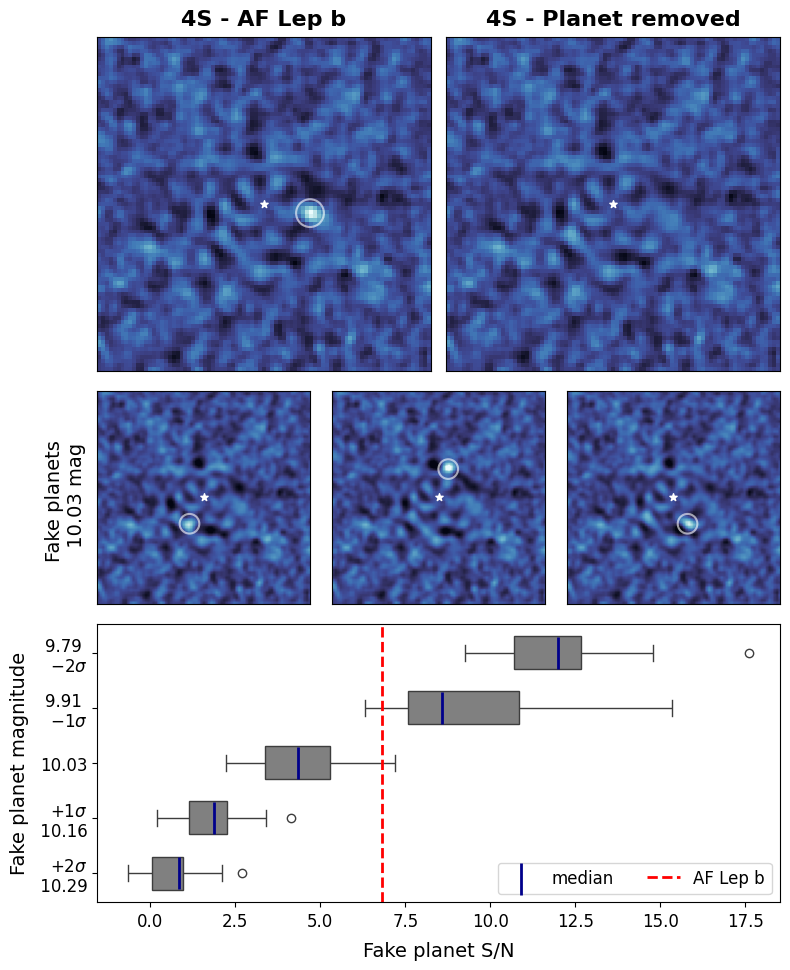

In [31]:
# Create the Large overview plot
# The layout is a 3x2 gridspec with:
# First row: Residual with AF Lep b, Residual without AF Lep b
# Second row: 3 examples of fake planets
# Third row: S/N of the fake planets
fig = plt.figure(figsize=(8, 9.8))
gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 0.8, 1])

# First row
ax1 = fig.add_subplot(gs[0, 0])
plot_residual_image(
    ax1,
    s4_mean_residual_with_planet,
    (0.32324, position_angle),
    marker_size=400)

ax1.set_title("4S - AF Lep b",
              y=1.01,
              fontweight="bold",
              fontsize=16)

ax2 = fig.add_subplot(gs[0, 1])
plot_residual_image(ax2, s4_mean_residual_no_planet, None)

ax2.set_title("4S - Planet removed",
              y=1.01,
              fontweight="bold",
              fontsize=16)

# Second row
gs01 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=gs[1, :], wspace=0.1)

for idx, tmp_residual in enumerate(selected_fake_planets):
    ax = fig.add_subplot(gs01[idx])
    plot_residual_image(
        ax,
        tmp_residual,
        (0.32324, fake_planet_angles[idx]),
    )

    if idx == 0:
        ax.set_ylabel("Fake planets \n 10.03 mag",
                      #fontweight="bold",
                      labelpad=8,
                      fontsize=14)


# Third row
ax3 = fig.add_subplot(gs[2, :])
sns.boxplot(snr_results_pd.T,
            color="gray",
            width=0.6,
            orient="h",
            ax=ax3,
            medianprops={"color": "r",
                         "linewidth": 2,
                         "alpha":0})

ax3.scatter(
    x=median_results,
    y=snr_results_pd.T.columns +2,
    color="darkblue",
    marker="|",
    s=500,
    lw=2,
    label="median",
    zorder=10)

# replace the y-ticks with the sigma values
# rotate the tick labels by 45 degrees
# Define the positions where you want the labels
tick_positions = np.array([-2, -1, 0, 1, 2])+2 

ax3.set_yticks(tick_positions)  # Set tick locations
ax3.yaxis.set_major_locator(ticker.FixedLocator(tick_positions))

ax3.set_yticklabels([
    "9.79 \n $-2 \\sigma$",
    "9.91 \n $-1 \\sigma$",
    "10.03",
    "$+1 \\sigma$ \n 10.16",
    "$+2 \\sigma$ \n 10.29"],
    rotation=0, fontsize=12)

# set the x-axis label size
ax3.tick_params(axis='x', labelsize=12)

# set the labels
ax3.set_ylabel("Fake planet magnitude", fontsize=14)
ax3.set_xlabel("Fake planet S/N", fontsize=14, labelpad=8)

# plot the S/N of AF Lep b as a vertical line
ax3.axvline(x=snr_af_lep,
            label="AF Lep b",
            color="r",
            linestyle="--",
            linewidth=2)

# add the legend in the bottom right corner
ax3.legend(loc="lower right", ncol=2,fontsize=12)

plt.tight_layout()

# save the figure
plt.savefig("./final_plots/0a6_AF_Lep_fake_planets.pdf",
            bbox_inches='tight')